In [515]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

- 외부데이터 추가한 train

In [518]:
train = pd.read_excel('./train.xlsx')
train = train[train['판매단가'] < train['취급액']]

In [519]:
train['노출(분)'] = train['노출(분)'].replace(0, math.nan)
train['노출(분)'] = train['노출(분)'].fillna(method='ffill')

- 외부데이터 추가 안한 train

In [520]:
data = pd.read_excel('./perfo.xlsx', header=1)
data = data[data['상품군']!='무형'] 
data = data[data['판매단가'] < data['취급액']]
data['날짜'] = pd.to_datetime(data['방송일시']).dt.date
data['날짜'] = pd.to_datetime(data['날짜'])
data['주문량'] = data['취급액']/data['판매단가']
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6}

In [521]:
#data[data['DATE']==pd.to_datetime('2019-06-15')].head(1)
#data[data['DATE']==pd.to_datetime('2019-08-31')].tail(1)

In [522]:
data = data.fillna(method='ffill')

In [523]:
data = data.iloc[17604:25792]

In [524]:
test = pd.read_excel('./test.xlsx')

# EDA

## 날씨/지역별

In [525]:
# 대표 지역들
places = ["강릉","광주","부산","수원","울산","대구","대전","서울","파주"] 
weather = pd.read_excel("./날씨_실제/강릉날씨.xlsx")
row_num = weather.shape[0]
weather["지역"]=["강릉"]*row_num

In [526]:
# 모든 지역 날씨 데이터 세로로 합치기
for p in places[1:]:
    a=pd.read_excel(f"./날씨_실제/{p}날씨.xlsx")
    a["지역"]=[p]*row_num
    weather = pd.concat([weather, a], axis=0)

In [527]:
# "-" -> 0값으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].replace("-",0)
weather["신적설(cm)"]=weather["신적설(cm)"].replace("-",0)
weather["운량(1/10)"]=weather["운량(1/10)"].replace("-",0)

# object 형 float 형으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].astype(float)
weather["신적설(cm)"]=weather["신적설(cm)"].astype(float)
weather["운량(1/10)"]=weather["운량(1/10)"].astype(float)

In [528]:
weather = weather.reset_index()

In [529]:
# 날짜 set 맞추기
new_weather = pd.DataFrame()
new_weather = weather.iloc[165:243]
new_weather = pd.concat([new_weather, weather.iloc[753:831]])
new_weather = pd.concat([new_weather, weather.iloc[1341:1419]])
new_weather = pd.concat([new_weather, weather.iloc[1929:2007]])
new_weather = pd.concat([new_weather, weather.iloc[2517:2595]])
new_weather = pd.concat([new_weather, weather.iloc[3105:3183]])
new_weather = pd.concat([new_weather, weather.iloc[3693:3771]])
new_weather = pd.concat([new_weather, weather.iloc[4281:4359]])
new_weather = pd.concat([new_weather, weather.iloc[4869:4947]])

In [530]:
# 서울 날씨와 강릉, 부산 날씨로 칼럼별 주문량 상관성 확인 및 지역별 날씨의 영향도 확인
gang_weather = new_weather.loc[new_weather["지역"]=="강릉",:]
seoul_weather = new_weather.loc[new_weather["지역"]=="서울",:]
busan_weather = new_weather.loc[new_weather["지역"]=="부산",:]
suwon_weather = new_weather.loc[new_weather["지역"]=="수원",:]
sudogwon_weather = new_weather.loc[(new_weather["지역"]=="서울")|(weather["지역"]=="수원"),:]

In [531]:
day_data = data.copy()

In [532]:
day_data['날짜'] = pd.to_datetime(day_data['날짜'])
new_weather['날짜'] = pd.to_datetime(new_weather['날짜'])

In [533]:
all_data = day_data.merge(new_weather, on='날짜')
all_data = all_data.groupby(['날짜']).mean()

In [534]:
sudogwon_weather['날짜'] = pd.to_datetime(sudogwon_weather['날짜'] )
seoul_weather['날짜'] = pd.to_datetime(seoul_weather['날짜'] )
busan_weather['날짜'] =pd.to_datetime(busan_weather['날짜'] )
suwon_weather['날짜'] = pd.to_datetime(suwon_weather['날짜'] )
gang_weather['날짜'] = pd.to_datetime(gang_weather['날짜'])

C:\Users\KSE\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\KSE\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\KSE\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [535]:
sudogwon_data = day_data.merge(sudogwon_weather, on="날짜")
suwon_data = day_data.merge(suwon_weather, on="날짜")
seoul_data = day_data.merge(seoul_weather, on="날짜")
busan_data = day_data.merge(busan_weather, on="날짜")
gang_data = day_data.merge(gang_weather, on="날짜")

In [536]:
# 시각화를 용이하게 하기 위한 데이터 전처리 함수
def preprocessing(data, bins=4):
    # 강수유무, 눈유무는 0,1 로 -> 비가오거나 눈이 쌓이면 1, 비가 오지 않거나 눈이 쌓이지 않으면 0
    data["강수유무"]=True
    data.loc[data["강수량(mm)"]!=0,"강수유무"]=1
    data.loc[data["강수량(mm)"]==0,"강수유무"]=0

    data["눈유무"]=True
    data.loc[data["신적설(cm)"]!=0,"눈유무"]=1
    data.loc[data["신적설(cm)"]==0,"눈유무"]=0

    # 나머지 칼럼은 6구간으로 나누기
    cate_columns= ["평균기온","최고기온","최저기온",'평균풍속(m/s)','평균습도(%)', '운량(1/10)', '일조시간(Hr)',"강수량(mm)","신적설(cm)"]
    
    for col in cate_columns:
        data[col]=pd.cut(data[col],bins)

In [537]:
# 데이터 전처리
for d in [all_data, seoul_data, busan_data, gang_data, sudogwon_data]:
    preprocessing(d,4)

In [538]:
# 시각화
visual_columns = all_data.columns[9:] # 시각화를 원하는 칼럼
visual_columns

Index(['평균기온', '최고기온', '최저기온', '강수량(mm)', '신적설(cm)', '평균풍속(m/s)', '평균습도(%)',
       '운량(1/10)', '일조시간(Hr)', '강수유무', '눈유무'],
      dtype='object')

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44512 missing from current font.
 

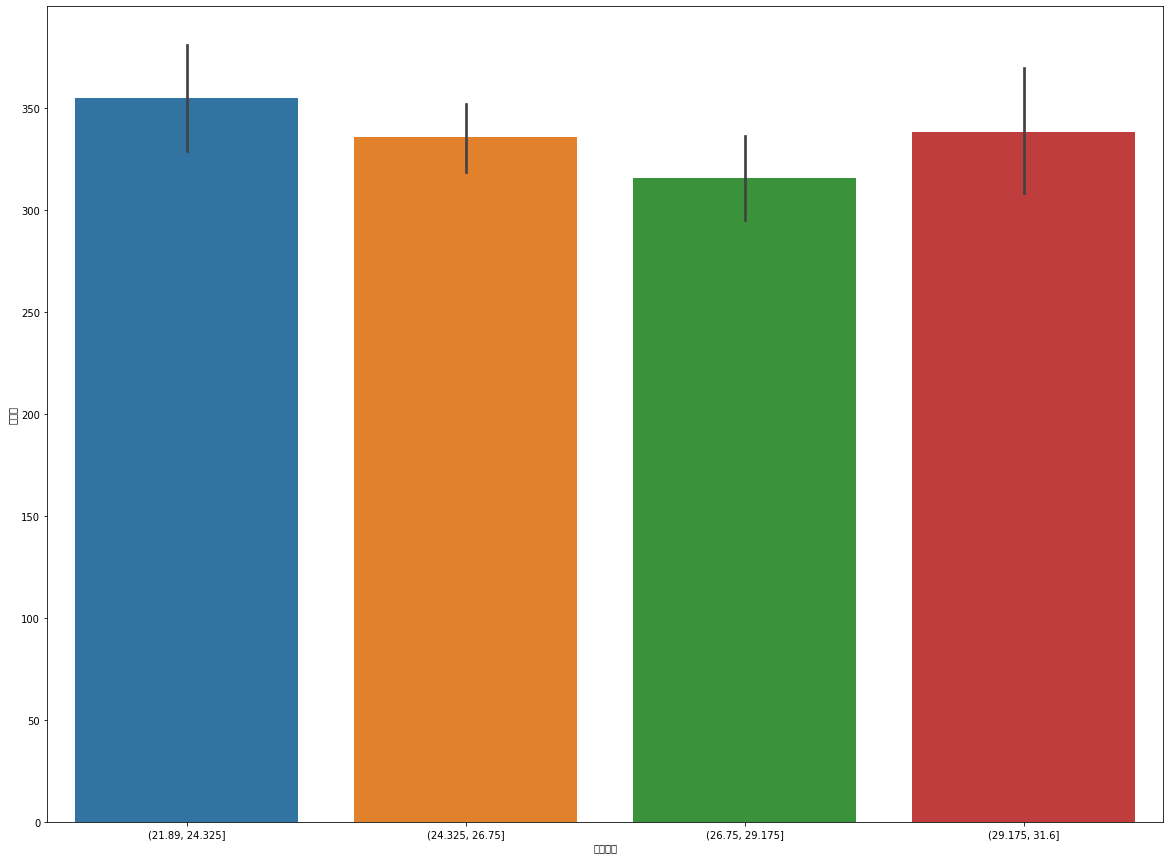

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44256 missing from current font.
 

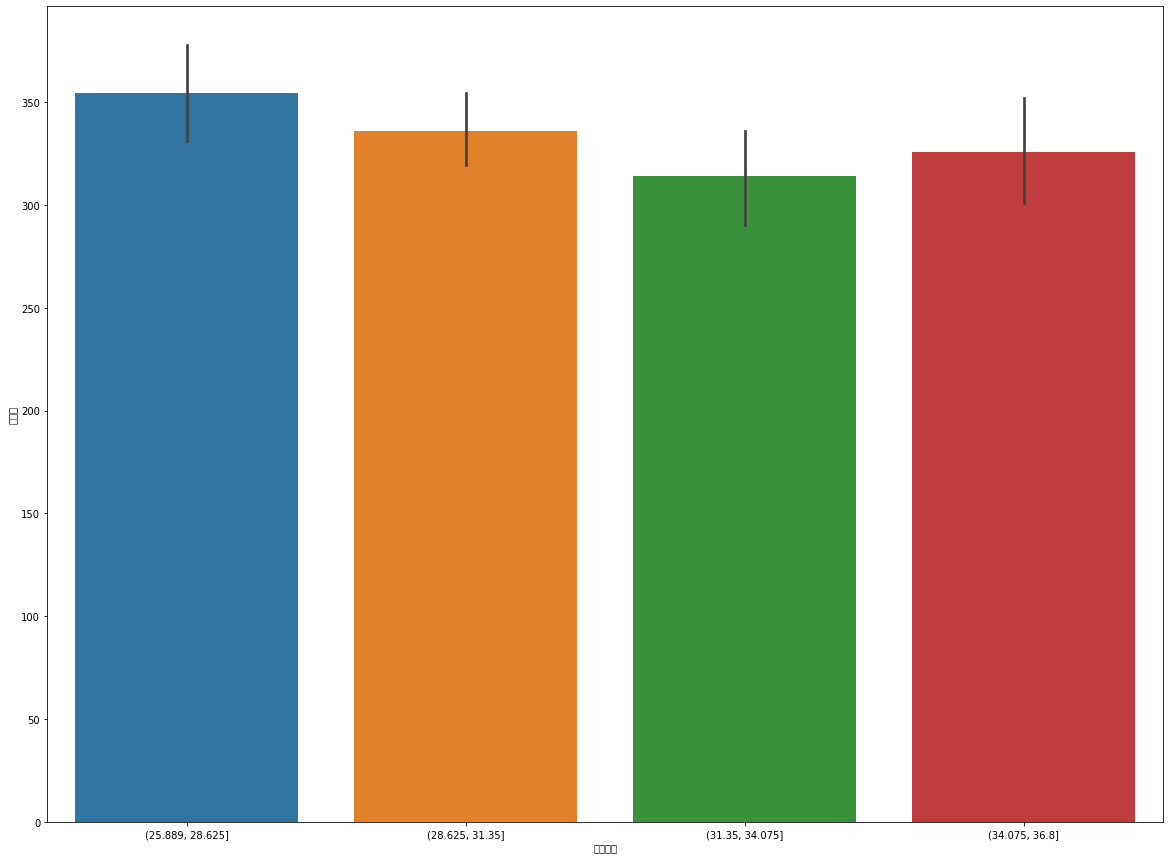

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52572 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51200 missing from current font.
 

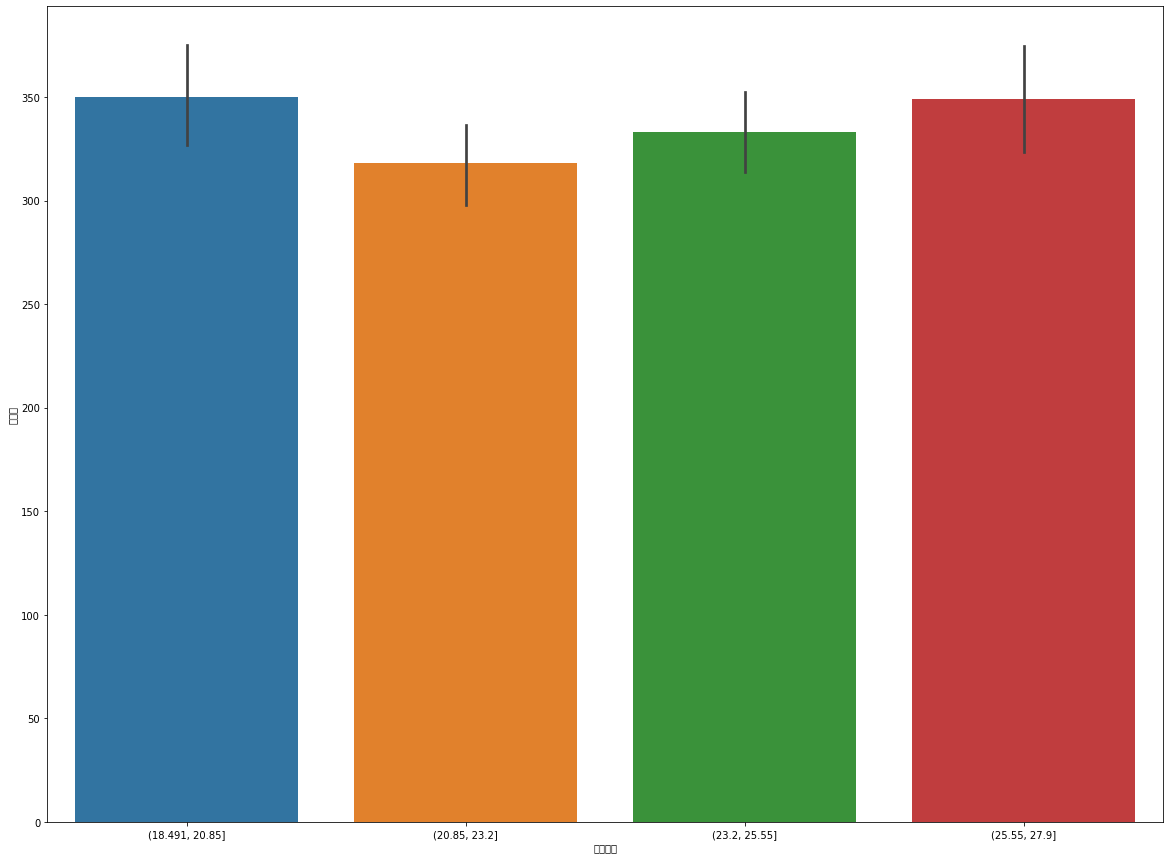

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47049 missing from current font.
  f

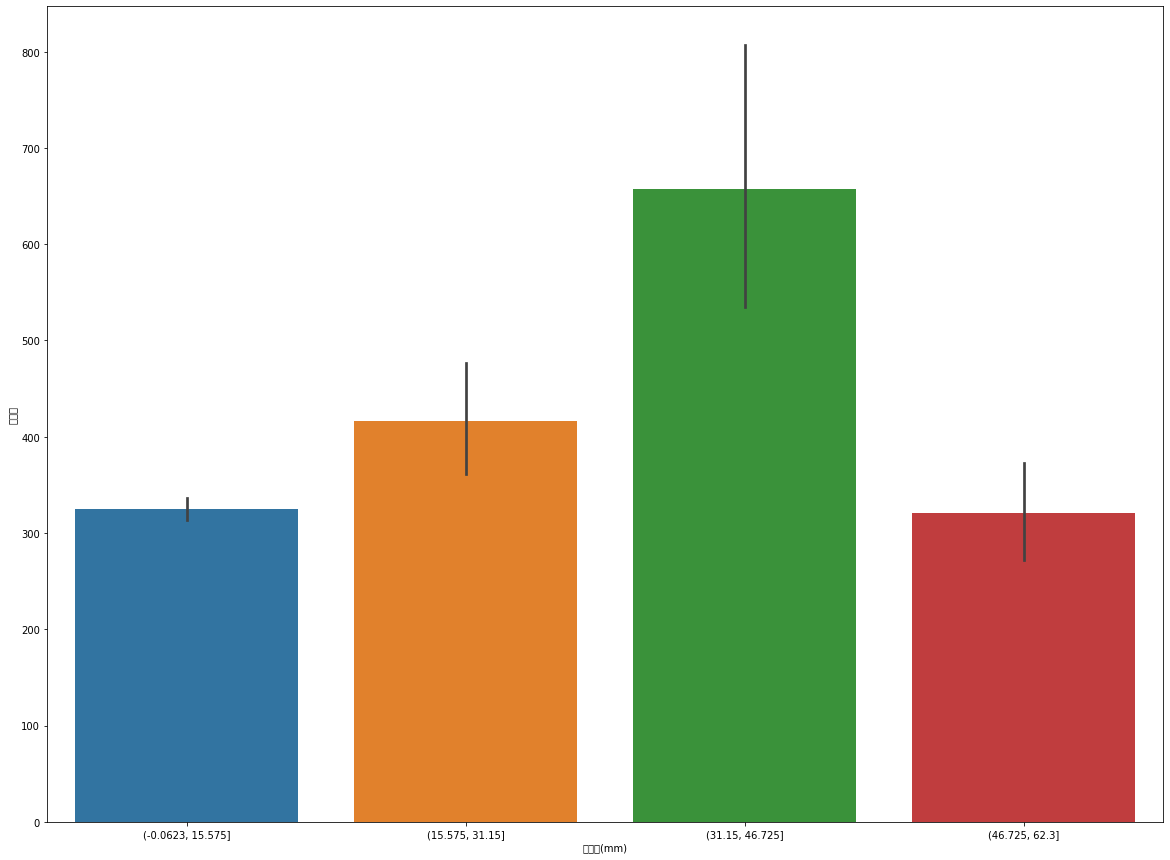

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49444 missing from current font.
  f

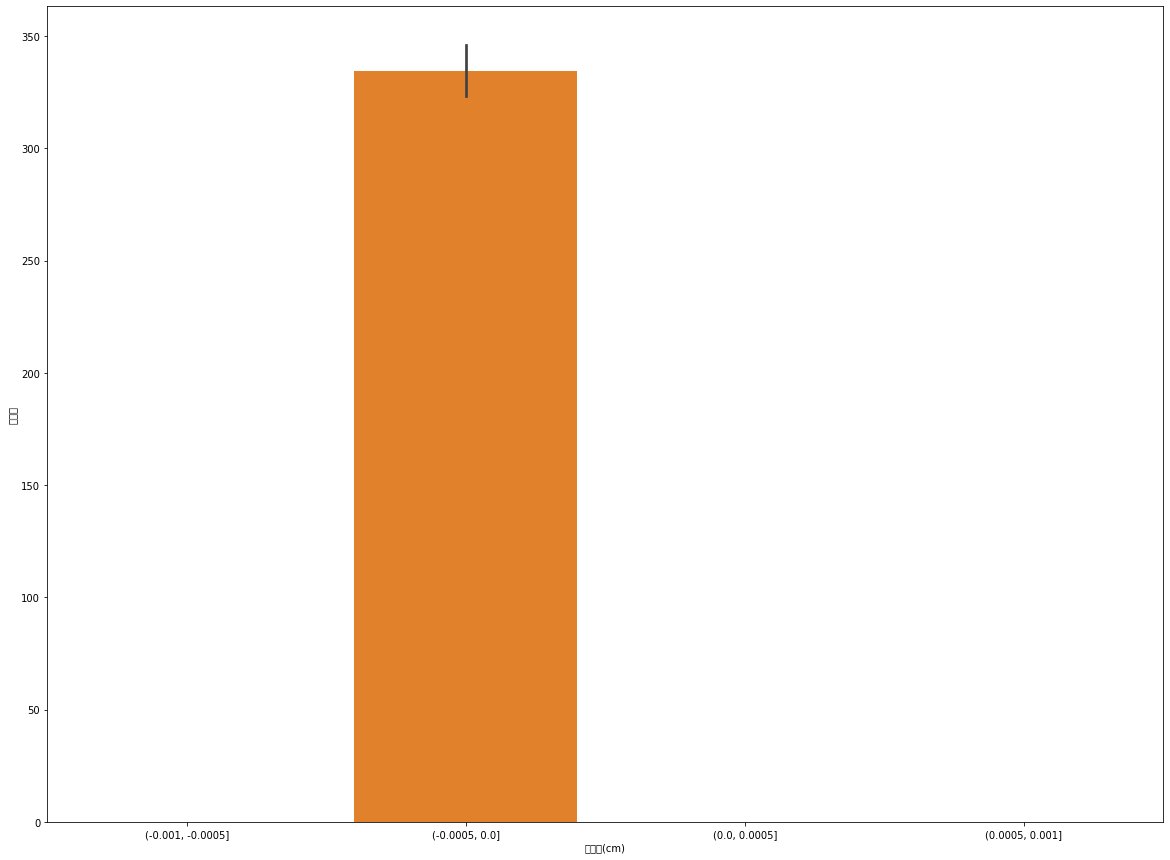

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44512 missing from current font.
 

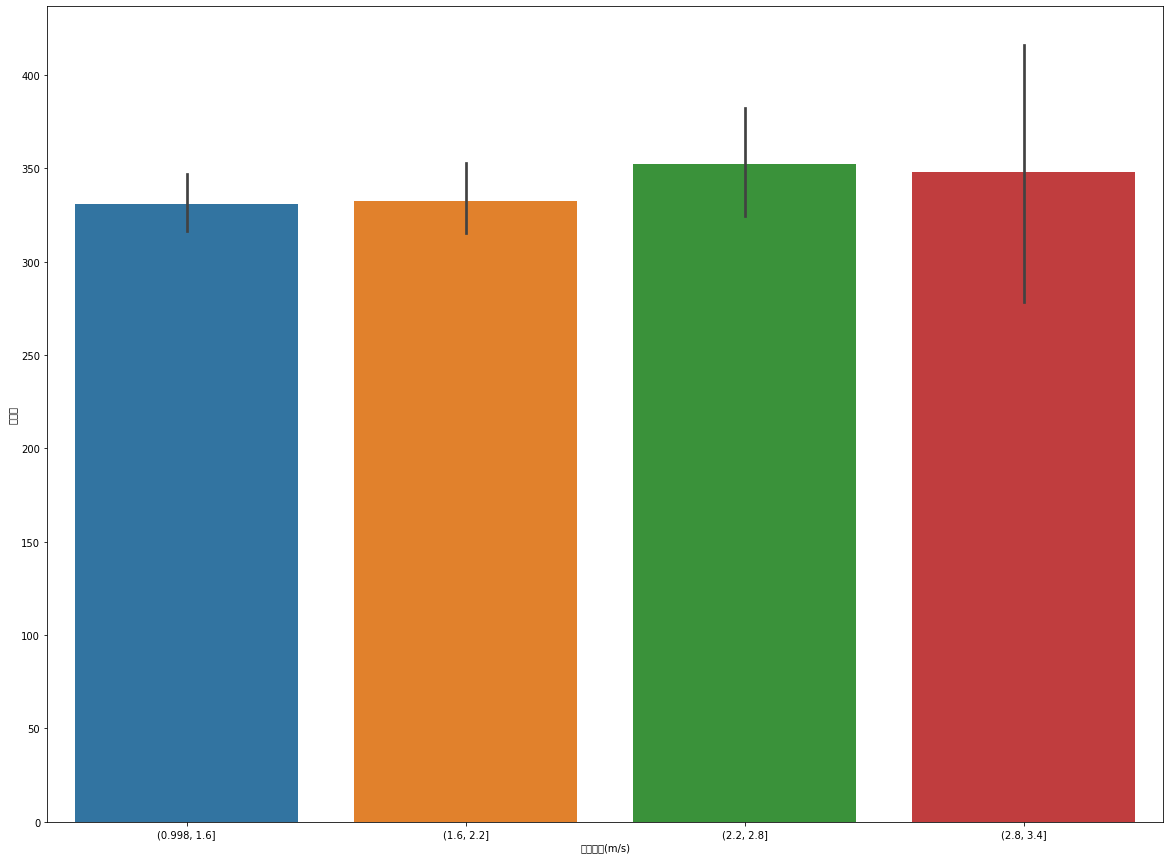

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44512 missing from current font.
 

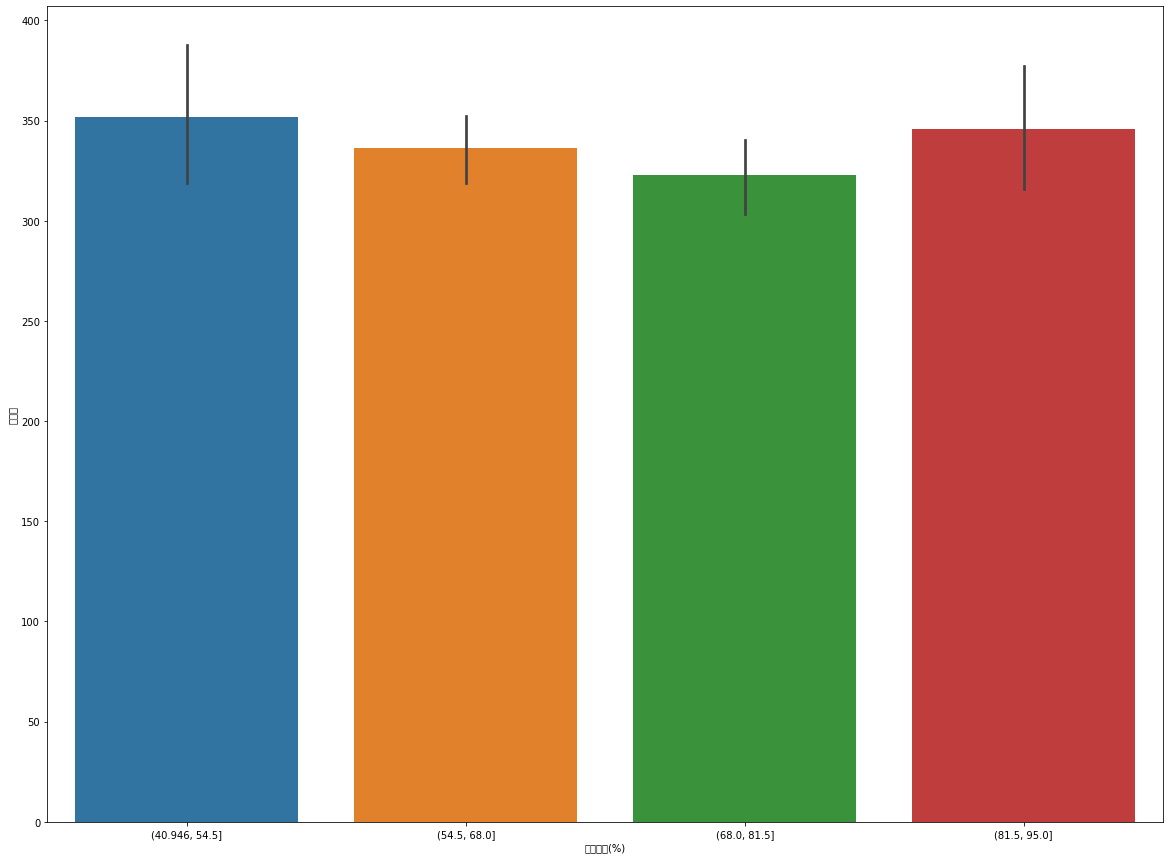

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50868 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  f

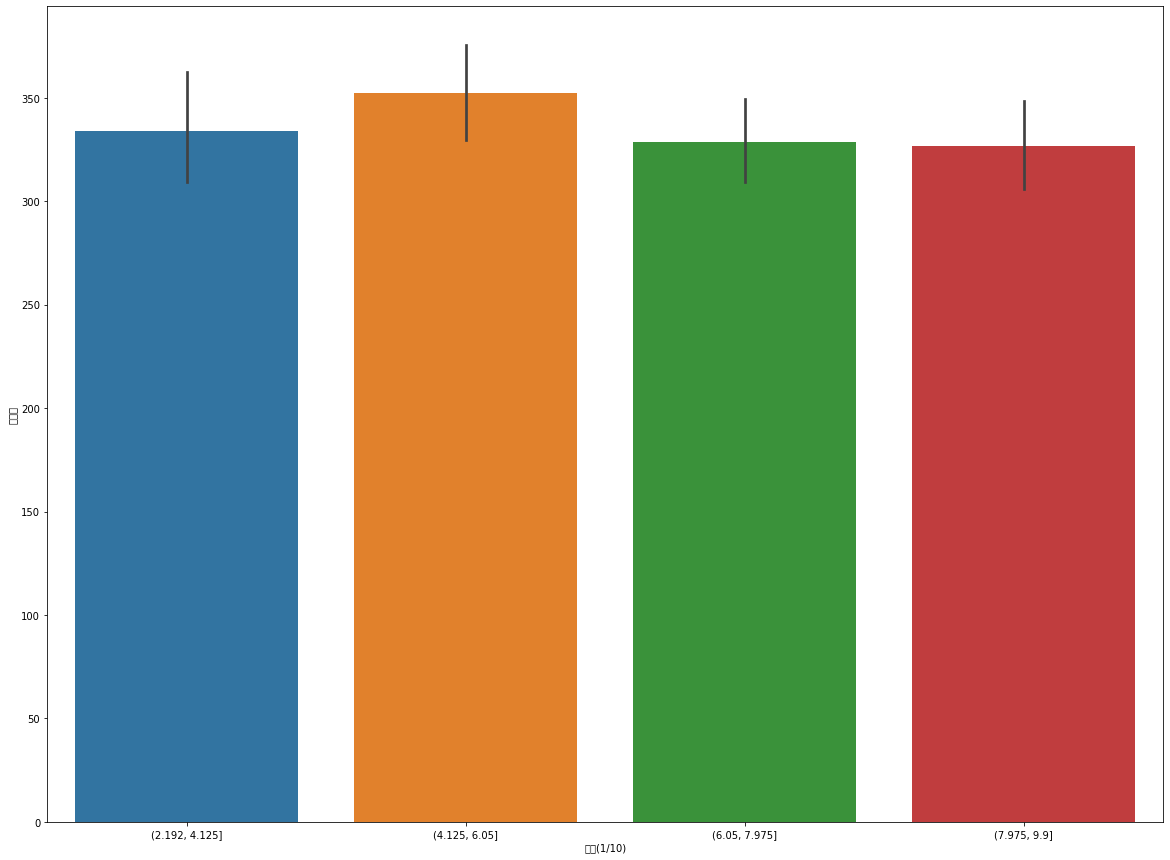

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51312 missing from current font.
 

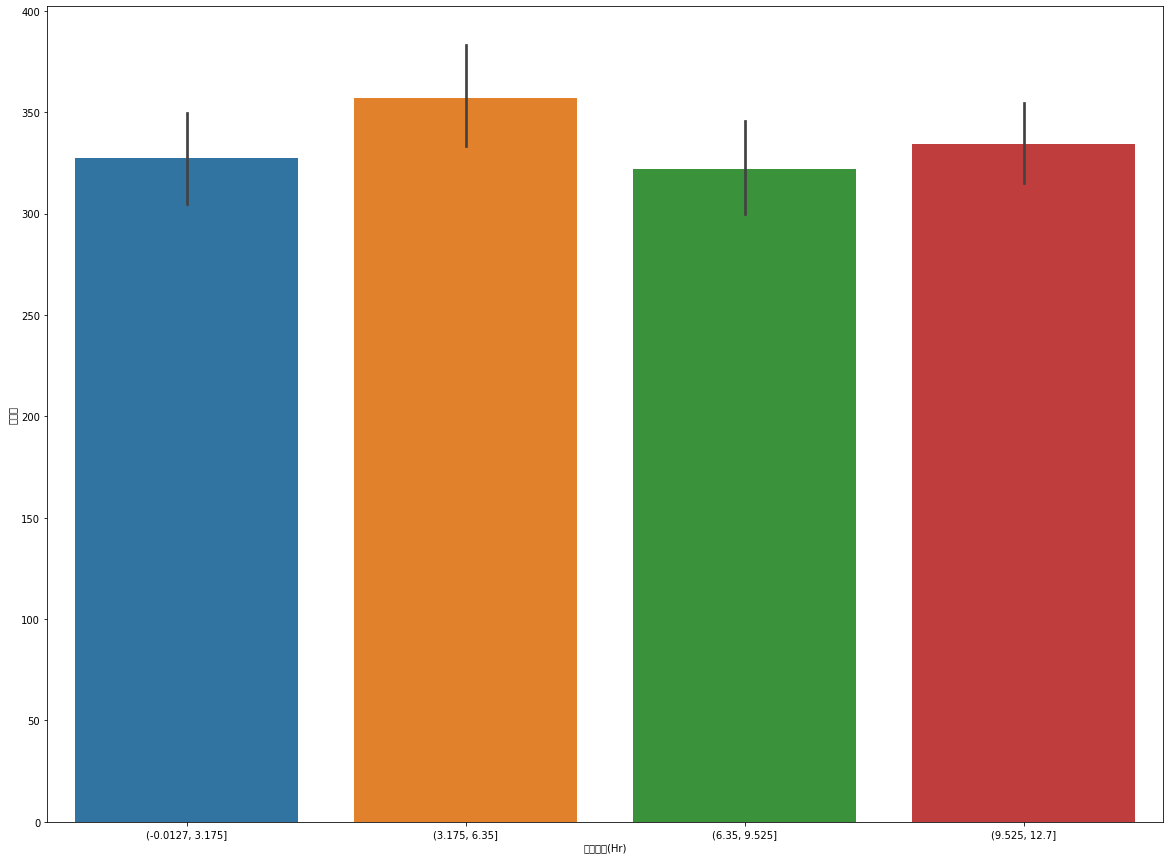

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
 

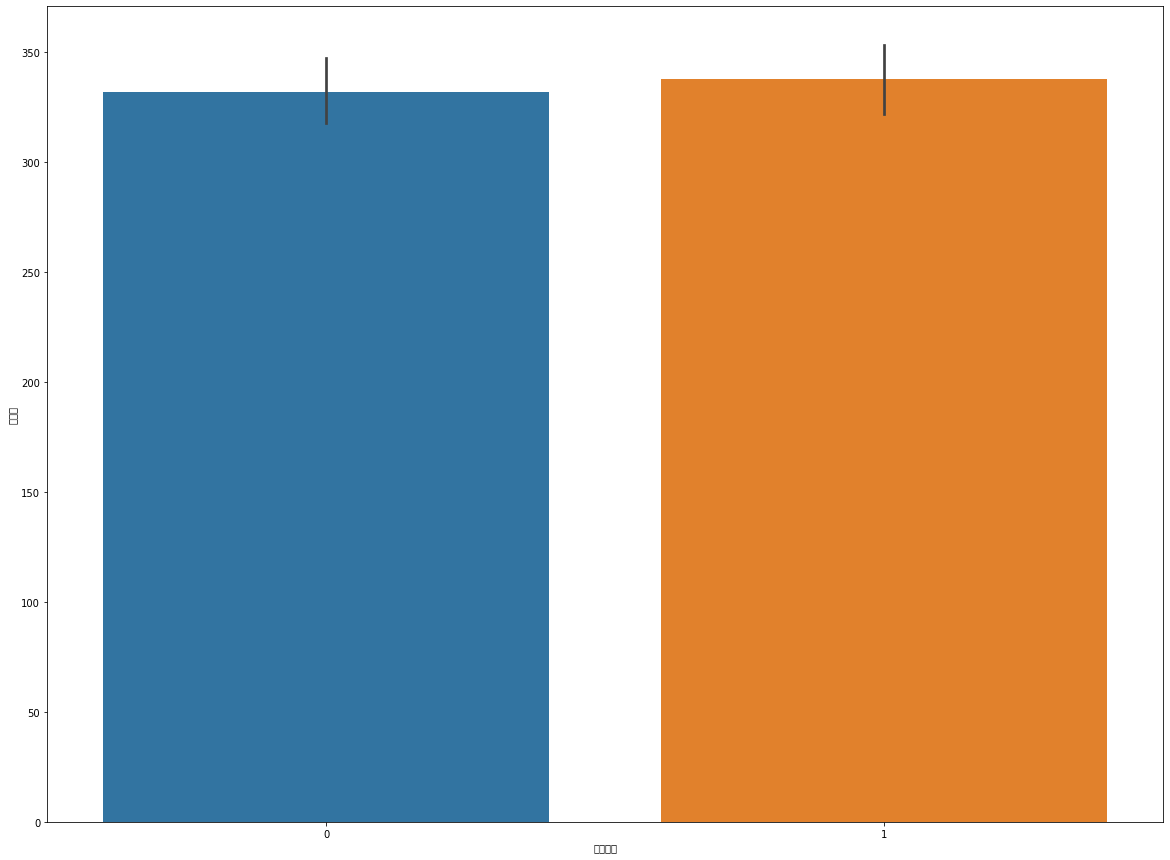

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45576 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45576 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47924 missing from current font.
  f

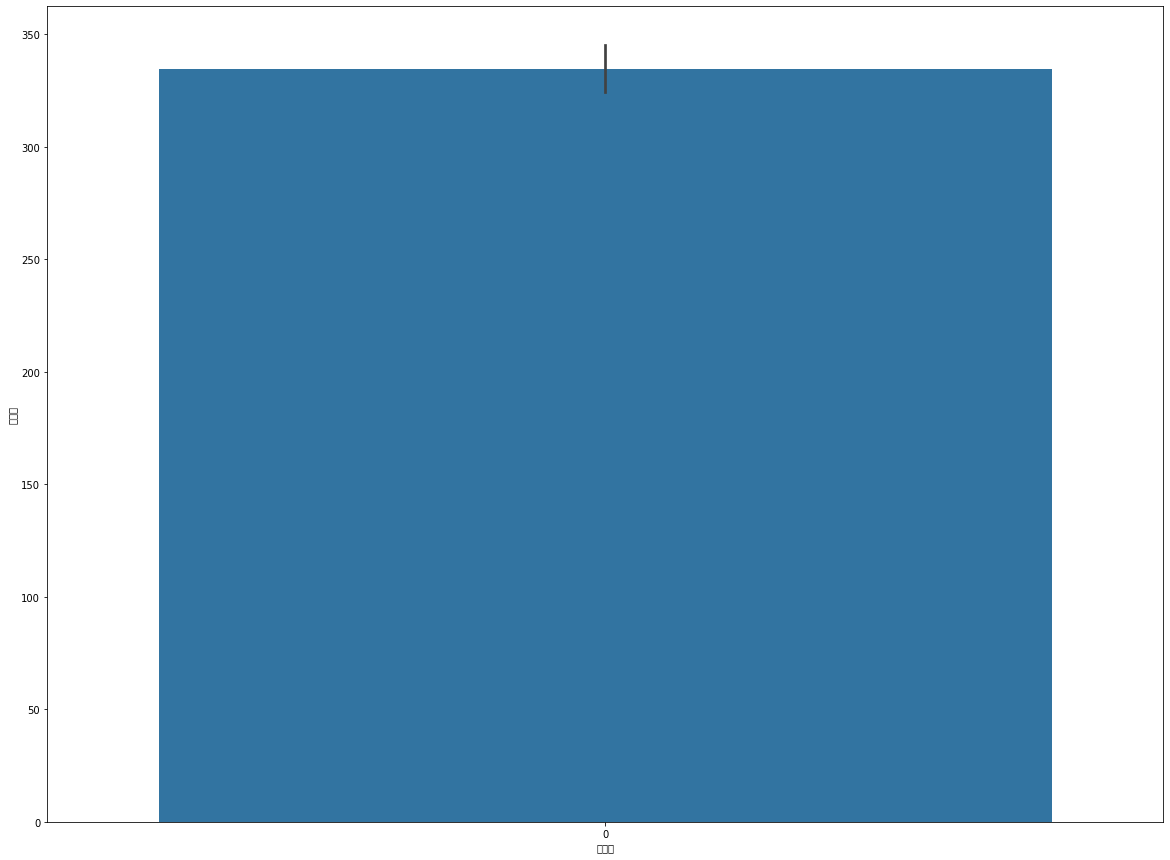

In [539]:
for col in visual_columns:
    sns.barplot(x=col, y="주문량", data=seoul_data)
    #plt.savefig(f'./날씨그래프/{col[:4]}.png') # 그래프 저장
    plt.show()

In [540]:
'''
# 요일성을 제거하고 특정 월에 대해서만 시각화
seoul_data["월"]=pd.to_datetime(seoul_data["방송일시"]).dt.month
a = seoul_data.loc[((seoul_data["요일"]!=5)&(seoul_data["요일"]!=6))&(seoul_data["월"]==7),:]
a["범주_습도"]=pd.cut(a["평균습도(%)"],4)
sns.barplot(x="범주_습도", y="주문량", data=a)
'''

'\n# 요일성을 제거하고 특정 월에 대해서만 시각화\nseoul_data["월"]=pd.to_datetime(seoul_data["방송일시"]).dt.month\na = seoul_data.loc[((seoul_data["요일"]!=5)&(seoul_data["요일"]!=6))&(seoul_data["월"]==7),:]\na["범주_습도"]=pd.cut(a["평균습도(%)"],4)\nsns.barplot(x="범주_습도", y="주문량", data=a)\n'

In [541]:
display(seoul_data.iloc[:,9:12].corr())
display(busan_data.iloc[:,9:12].corr())
display(gang_data.iloc[:,9:12].corr())

,주문량,요일,시
주문량,1.000000,0.017263,-0.098928
요일,0.017263,1.000000,-0.021874
시,-0.098928,-0.021874,1.000000


,주문량,요일,시
주문량,1.000000,0.017263,-0.098928
요일,0.017263,1.000000,-0.021874
시,-0.098928,-0.021874,1.000000


,주문량,요일,시
주문량,1.000000,0.017263,-0.098928
요일,0.017263,1.000000,-0.021874
시,-0.098928,-0.021874,1.000000


## 미세먼지

In [542]:
munji = pd.read_excel('./munji/2019미세먼지.xlsx')
pop_tot = pd.read_excel('./munji/2019총인구비율(수정).xlsx')
pop_w = pd.read_excel('./munji/2019여성인구비율.xlsx')
pop_m = pd.read_excel('./munji/2019남자인구비율.xlsx')

In [543]:
#먼지DF, 인구DF주면 가중치먼지 계산해서 돌려줌

def weighted_munji(munji_data,population_data): 
    weighted_df = pd.DataFrame()
    weighted_df = pd.DataFrame().reindex_like(munji_data)
    for i in range(len(munji_data.index)):
        for j in range(len(munji_data.columns)):
            weighted_df.iloc[i][j] = munji_data.iloc[i][j]*population_data.iloc[i][j]
    return weighted_df

In [544]:
#모든 카테고리와의 상관계수 결과 반환해줌
def cor_with_categories(data): 
    results = []
    results.append(stats.linregress(month_침구,data.iloc[month_침구.index-1]))
    results.append(stats.linregress(month_가구,data.iloc[month_가구.index-1]))
    results.append(stats.linregress(month_건강기능,data.iloc[month_건강기능.index-1]))
    results.append(stats.linregress(month_농수축,data.iloc[month_농수축.index-1]))
    results.append(stats.linregress(month_생활용품,data.iloc[month_생활용품.index-1]))
    results.append(stats.linregress(month_속옷,data.iloc[month_속옷.index-1]))
    results.append(stats.linregress(month_의류,data.iloc[month_의류.index-1]))
    results.append(stats.linregress(month_이미용,data.iloc[month_이미용.index-1]))
    results.append(stats.linregress(month_잡화,data.iloc[month_잡화.index-1]))
    results.append(stats.linregress(month_주방,data.iloc[month_주방.index-1]))
    results.append(stats.linregress(month_침구,data.iloc[month_침구.index-1]))
    print('침구,가구,건강기능,농수축,생활용품,속옷,의류,이미용,잡화,주방,침구')
    
    return results

1) 총 인구수 고려

In [545]:
munji_df = munji.set_index('지역날짜')
pop_tot_df = pop_tot.set_index('행정구역(시군구)별')

In [546]:
tot_weight_munji = weighted_munji(munji_df, pop_tot_df)

In [547]:
tot_munji_df = tot_weight_munji.sum()
tot_munji_df

2019. 01    24.837347
2019. 02    22.833675
2019. 03    27.869383
2019. 04    13.450065
2019. 05    18.012409
2019. 06    12.980445
2019. 07    11.941034
2019. 08    11.264766
2019. 09     8.645412
2019. 10    10.491966
2019. 11    13.959968
2019. 12    18.588743
dtype: float64

In [548]:
MonthItemGroup = train.groupby(['상품군','월']).mean()

In [549]:
# 6,7,8 월만 전체인구수가중한것과 건강기능 상관계수
stats.linregress(tot_munji_df[5:8], MonthItemGroup.xs('health')['주문량'])

LinregressResult(slope=99.30943820204276, intercept=-820.7029264126979, rvalue=0.9144962032725028, pvalue=0.26517464159491627, stderr=43.93681513571076)

2) 여성 인구수 고려

In [550]:
pop_w_df = pop_w.set_index('행정구역(시군구)별')

In [551]:
woman_weight_munji = weighted_munji(munji_df, pop_w_df)

In [552]:
woman_munji_df = woman_weight_munji.sum()
woman_munji_df

2019. 01    12.484569
2019. 02    11.481677
2019. 03    14.014574
2019. 04     6.766506
2019. 05     9.061288
2019. 06     6.532986
2019. 07     6.008642
2019. 08     5.665599
2019. 09     4.347492
2019. 10     5.275934
2019. 11     7.020567
2019. 12     9.352337
dtype: float64

- 확인 필요

In [553]:
stats.linregress(woman_munji_df[5:8], MonthItemGroup.xs('health')['주문량'])

LinregressResult(slope=196.5989557714752, intercept=-815.9983069564603, rvalue=0.915102904851042, pvalue=0.2642183874640637, stderr=86.62709397289866)

3) 남녀 비율 조정해서 고려(홈쇼핑 이용 비율 8:2)

In [554]:
pop_m_df = pop_m.set_index('행정구역(시군구)별')

In [555]:
mix_weight_munji = 0.2*weighted_munji(munji_df, pop_m_df) +\
                    0.8*weighted_munji(munji_df, pop_w_df)

In [556]:
mix_munji_df = mix_weight_munji.sum()
mix_munji_df

2019. 01    12.458211
2019. 02    11.455741
2019. 03    13.982621
2019. 04     6.749916
2019. 05     9.039254
2019. 06     6.515881
2019. 07     5.993392
2019. 08     5.652313
2019. 09     4.337577
2019. 10     5.263954
2019. 11     7.004334
2019. 12     9.329150
dtype: float64

- 확인필요

## 월별/요일별

- 월별 주문량

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 50900 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font

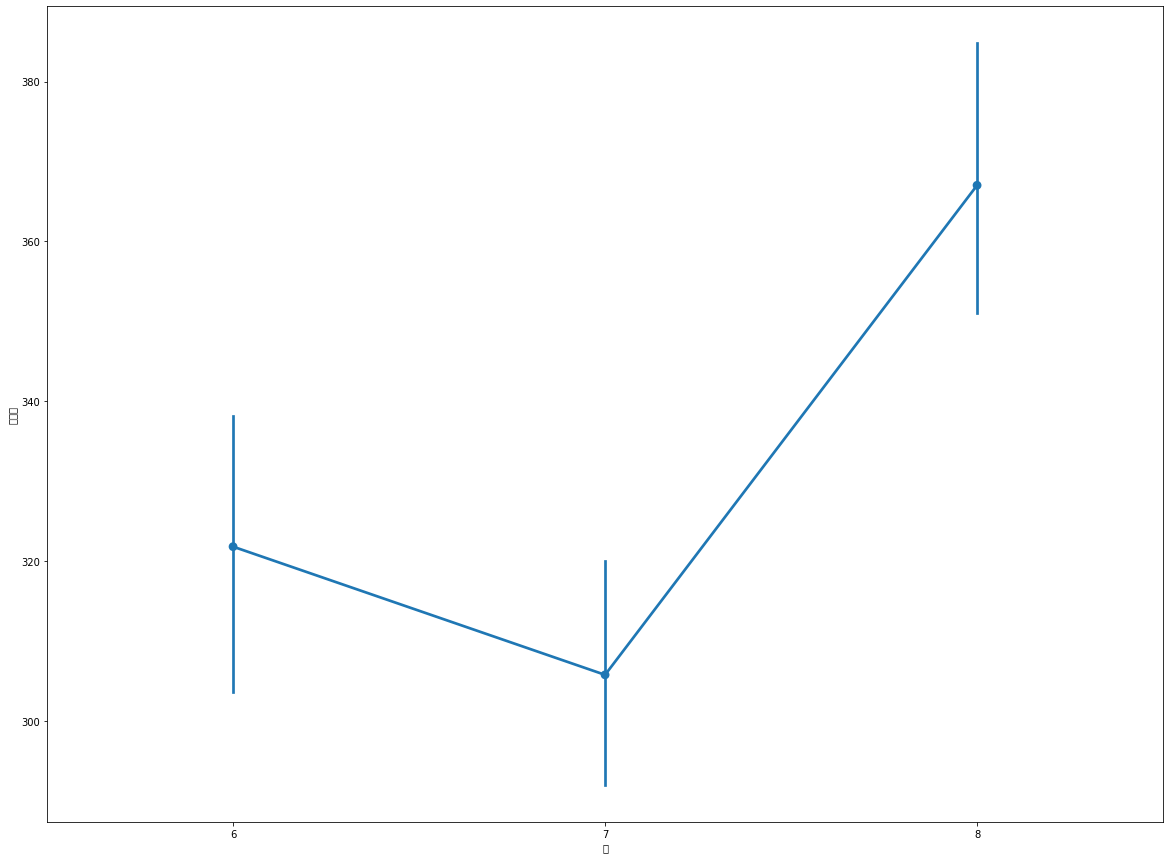

In [557]:
sns.pointplot(data=train,x="월",y="주문량")

- 요일별 주문량

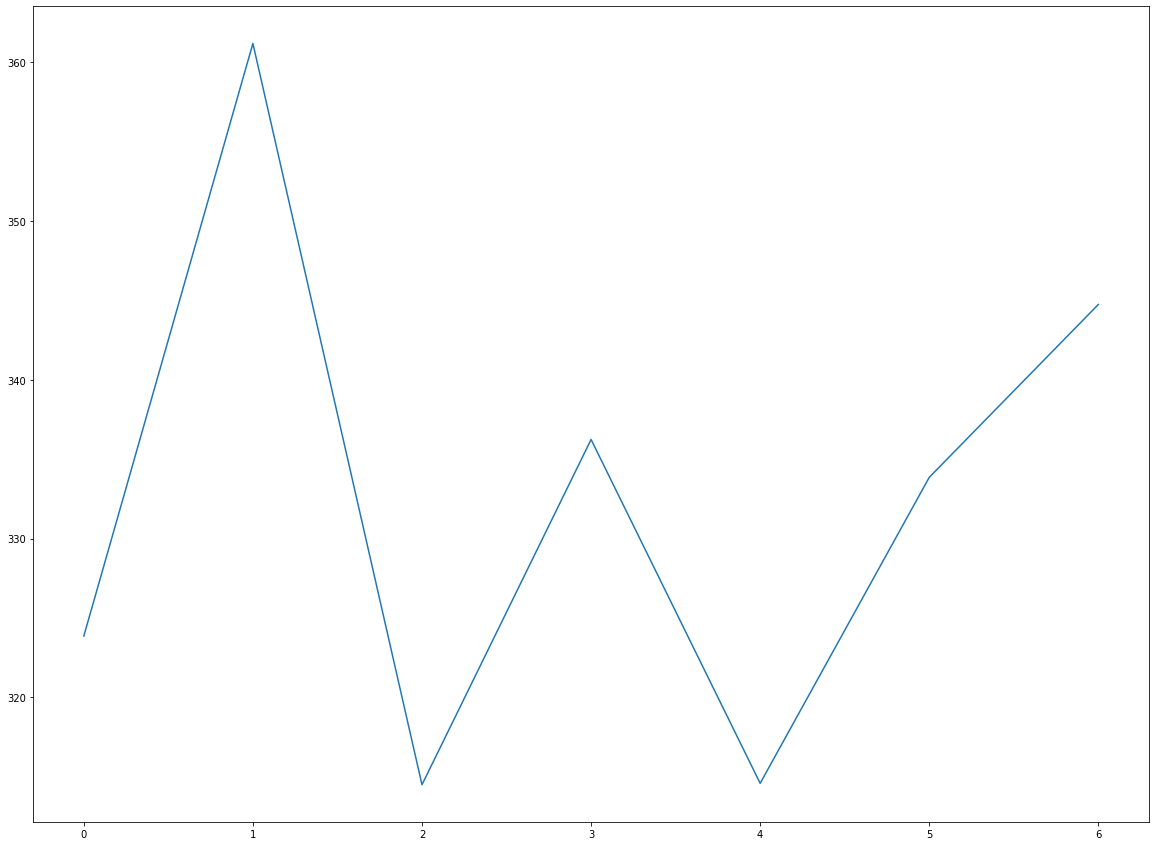

In [558]:
plt.plot(train.groupby("요일")["주문량"].sum()/train.groupby("요일")["주문량"].count())

In [559]:
(train.groupby("요일")["주문량"].sum()/train.groupby("요일")["주문량"].count()).describe()

count      7.000000
mean     332.715900
std       16.869934
min      314.504503
25%      319.230204
50%      333.862742
75%      340.498297
max      361.187054
Name: 주문량, dtype: float64

## 상품군/마더코드별

In [560]:
train['상품군'].value_counts()

living       1281
elec         1014
etc          1002
food          955
inner         878
cloth         818
furniture     461
life          430
bedding       282
beauty        216
health        176
Name: 상품군, dtype: int64

- 전체 만더코드별 주문량

In [561]:
mother_grouped = train.groupby('마더코드')
MomCodeGroup = mother_grouped.sum()['주문량']

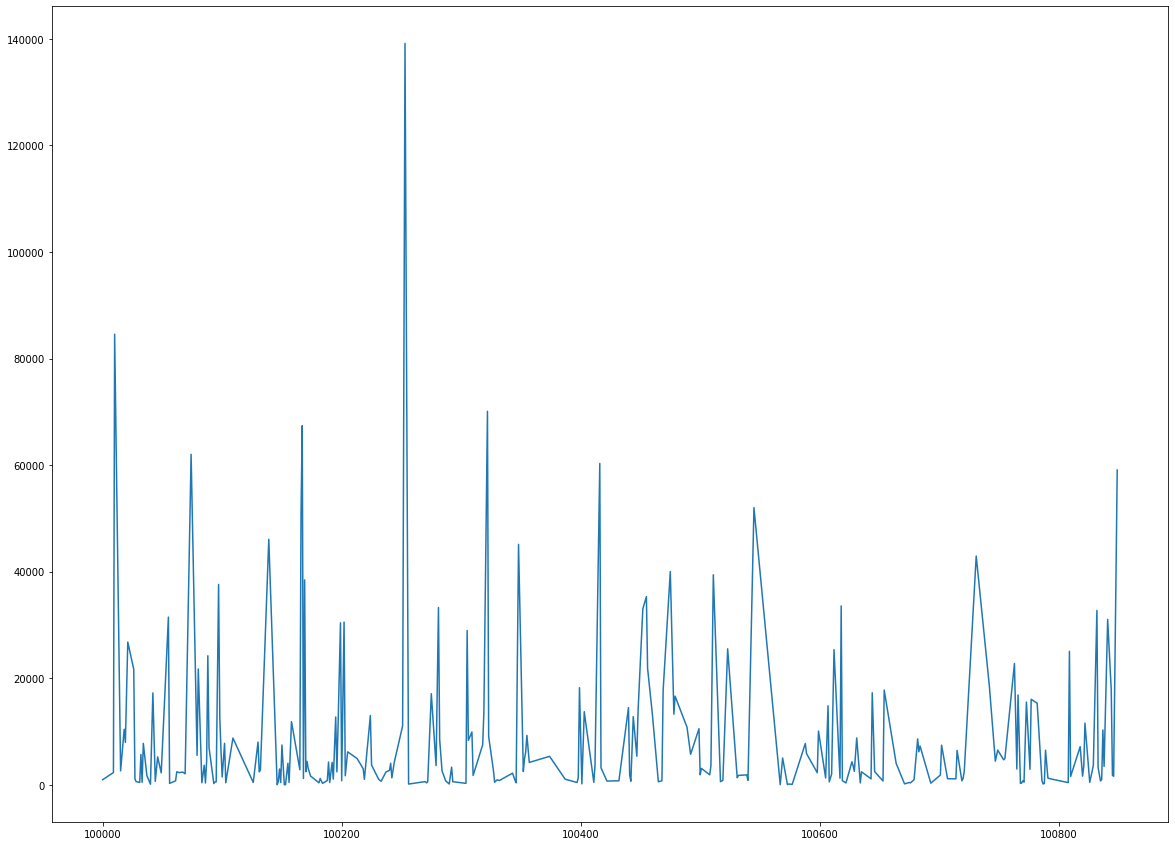

In [562]:
plt.plot(MomCodeGroup)

- 노출시간 대비 주문량 높은 마더코드

In [563]:
MomCodeGroup2 = train.groupby(['마더코드']).sum()

In [564]:
MomCodeGroup2['주문량/노출'] = MomCodeGroup2['주문량']/MomCodeGroup2['노출(분)']
MomCodeGroup2.sort_values('주문량/노출', ascending=False).head()

,Unnamed: 0,노출(분),상품코드,판매단가,취급액,요일,시,주문량,holiday,월,...,DATE,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥),MONTH,HOUR,주문량/노출
마더코드,,,,,,,,,,,,,,,,,,,,,
100492,75615,60.0,604461,149700,286104000,9,48,5733.547094,0,24,...,60572487,83.88,60.24,0.10620,0.06084,1.500,0.01080,24,48,95.559118
100499,145080,120.0,1209006,239400,420256000,15,117,10532.731830,0,48,...,121144908,136.44,83.28,0.19428,0.10164,2.532,0.02136,48,117,87.772765
100046,151203,60.0,1200756,185400,162001000,18,90,5242.750809,0,48,...,121144974,167.76,120.48,0.21240,0.12168,3.000,0.02160,48,90,87.379180
100754,76092,60.0,606609,119700,187163000,15,39,4690.802005,0,24,...,60572493,49.68,28.08,0.09552,0.05016,1.152,0.01020,24,39,78.180033
100323,151497,120.0,1208934,299400,452290000,21,99,9063.927856,0,48,...,121144977,138.12,85.56,0.21396,0.11016,2.520,0.02136,48,99,75.532732


In [566]:
topcode = list(MomCodeGroup2.sort_values('주문량/노출', ascending=False).index[:50])

- 상품군 내 마더코드별 주문량

In [352]:
multi_grouped = train.groupby(['상품군','마더코드'])
MultiGroup = multi_grouped['주문량'].sum()
MultiGroup = MultiGroup.reset_index()

In [353]:
item = list(set(MultiGroup['상품군']))

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45908 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45908 missing from current font.
 

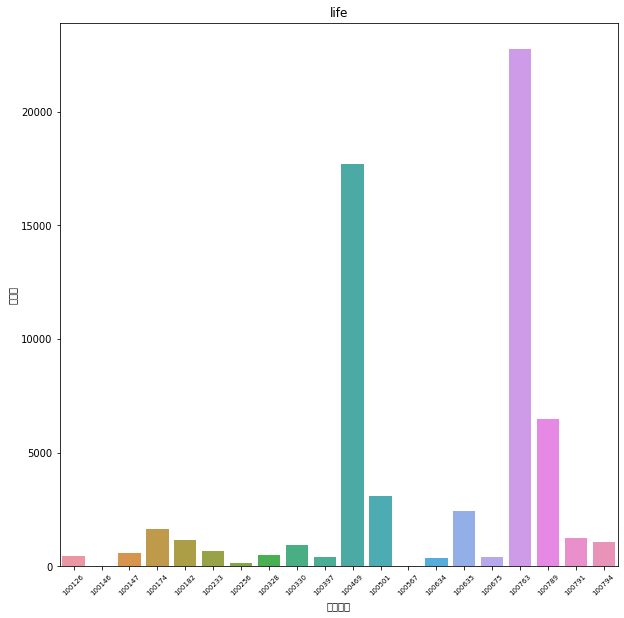

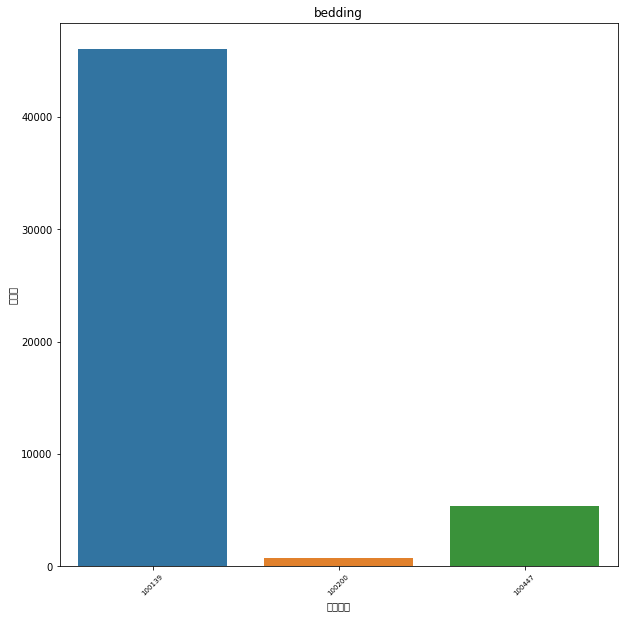

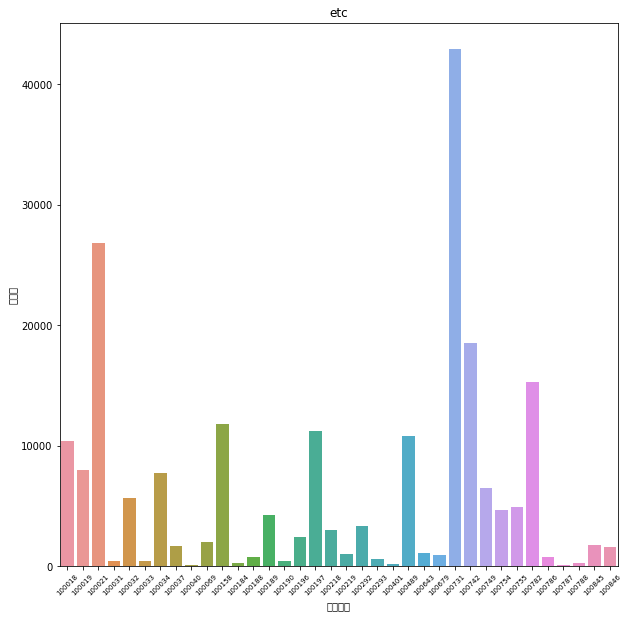

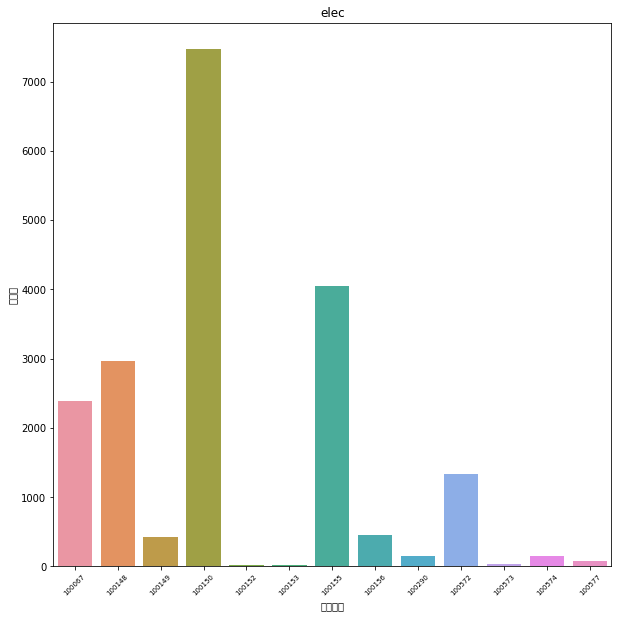

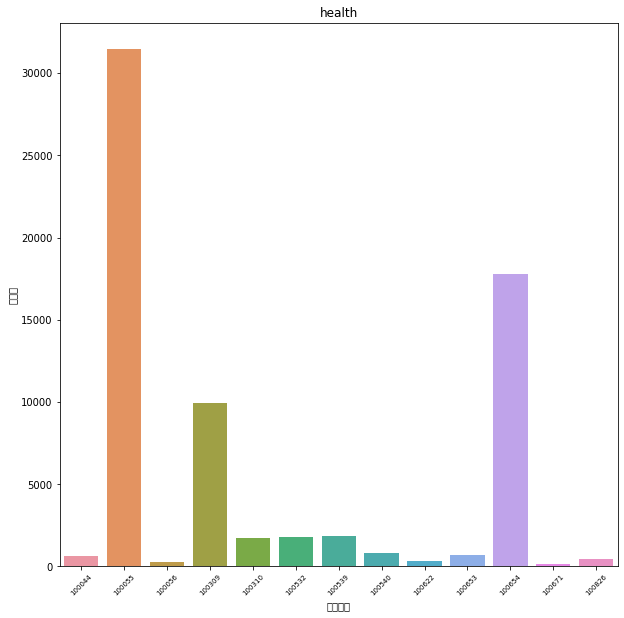

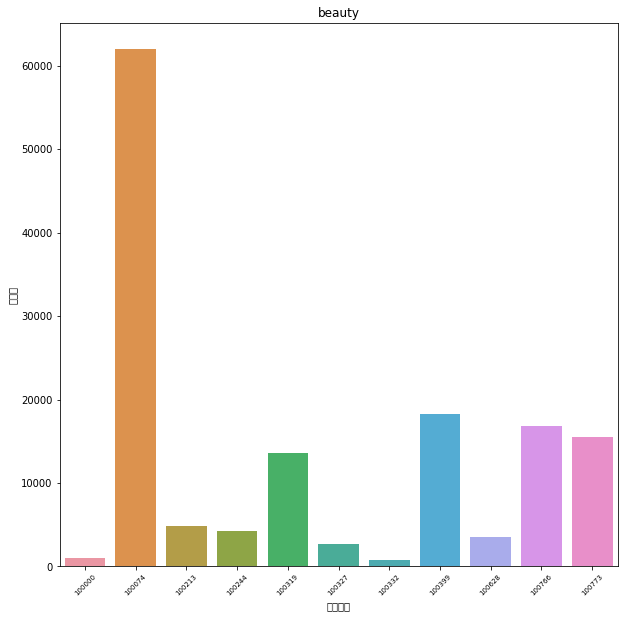

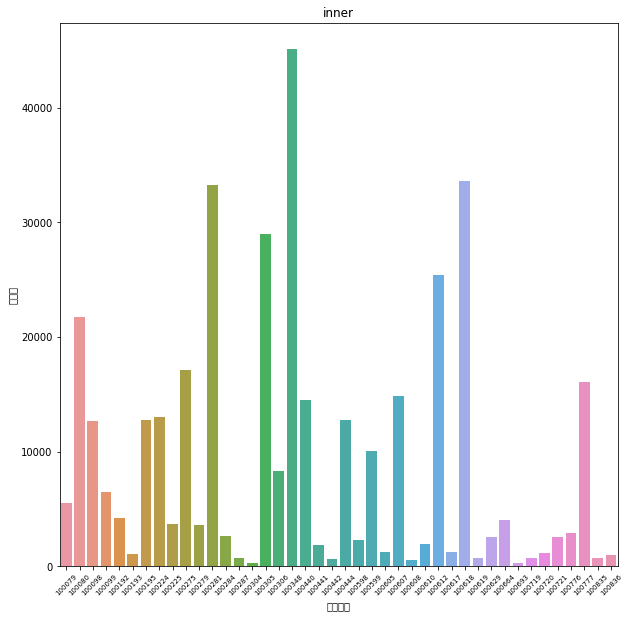

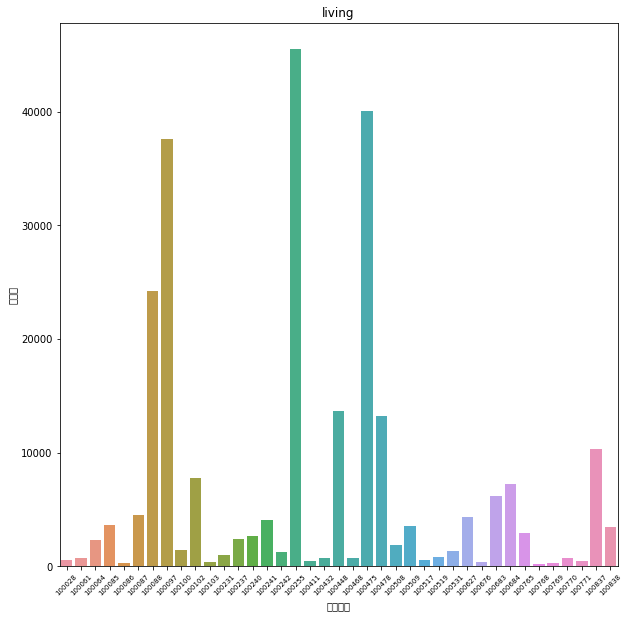

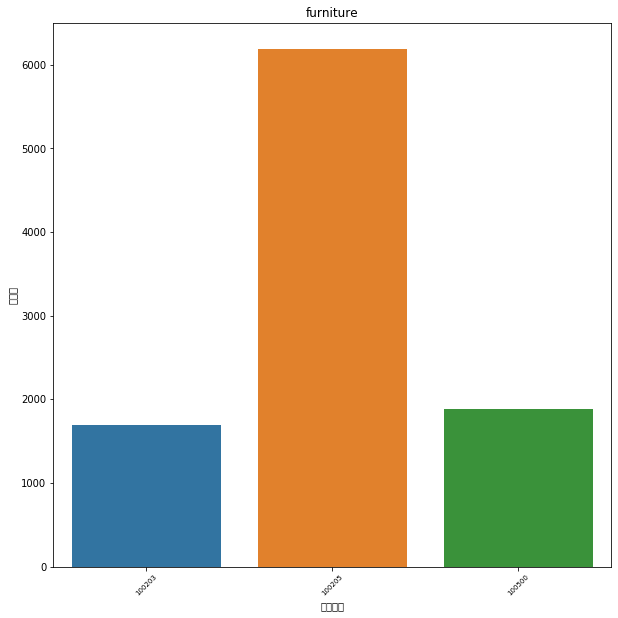

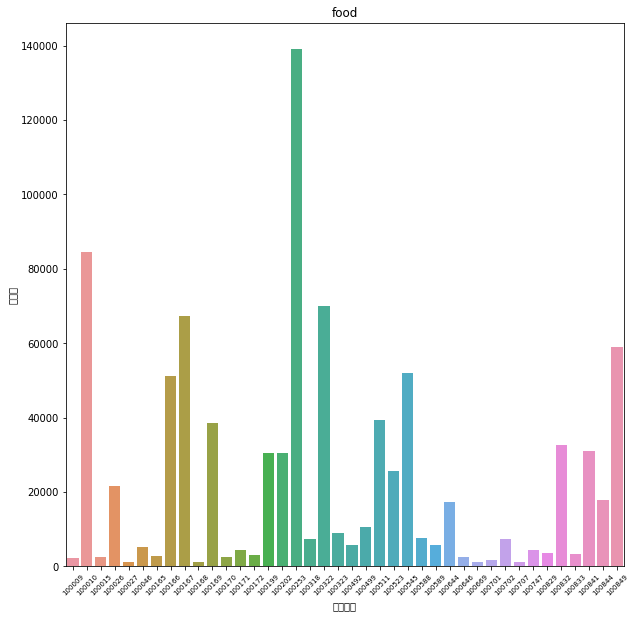

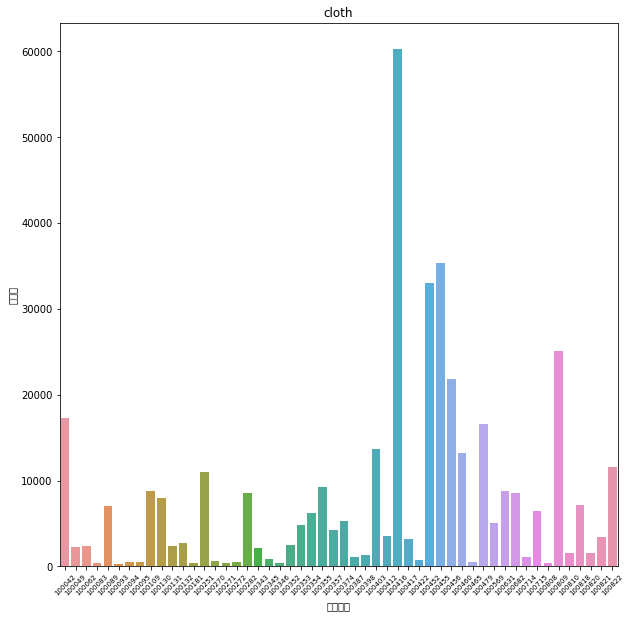

In [355]:
for i in item:
    plt.figure(figsize=(10,10))
    sns.barplot(data=MultiGroup[MultiGroup['상품군']==i], x='마더코드', y='주문량')
    plt.title(i)
    plt.xticks(rotation=45, size=7)

## /시간대별 + 상품군/마더코드별

- 시간대 상품군별 주문량

In [349]:
hour_grouped = train.groupby(['시','상품군'])
HourGroup = hour_grouped['주문량'].sum()
HourGroup = HourGroup.reset_index()

C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 49884 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KSE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font

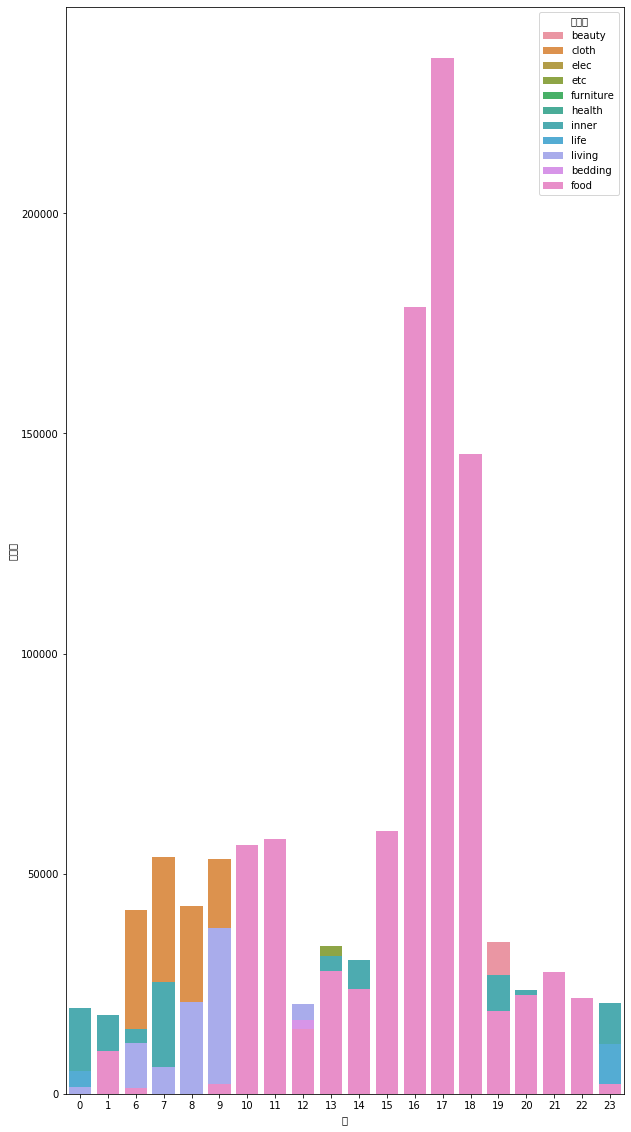

In [350]:
plt.figure(figsize=(10,20))
sns.barplot(data=HourGroup, x='시', y='주문량', hue='상품군', dodge=False)

## 판매단가

In [362]:
np.corrcoef(train['주문량'],train['판매단가'])

array([[ 1.        , -0.39377501],
       [-0.39377501,  1.        ]])

In [363]:
np.corrcoef(train['주문량'],np.log(train['판매단가']))

array([[ 1.        , -0.61081947],
       [-0.61081947,  1.        ]])

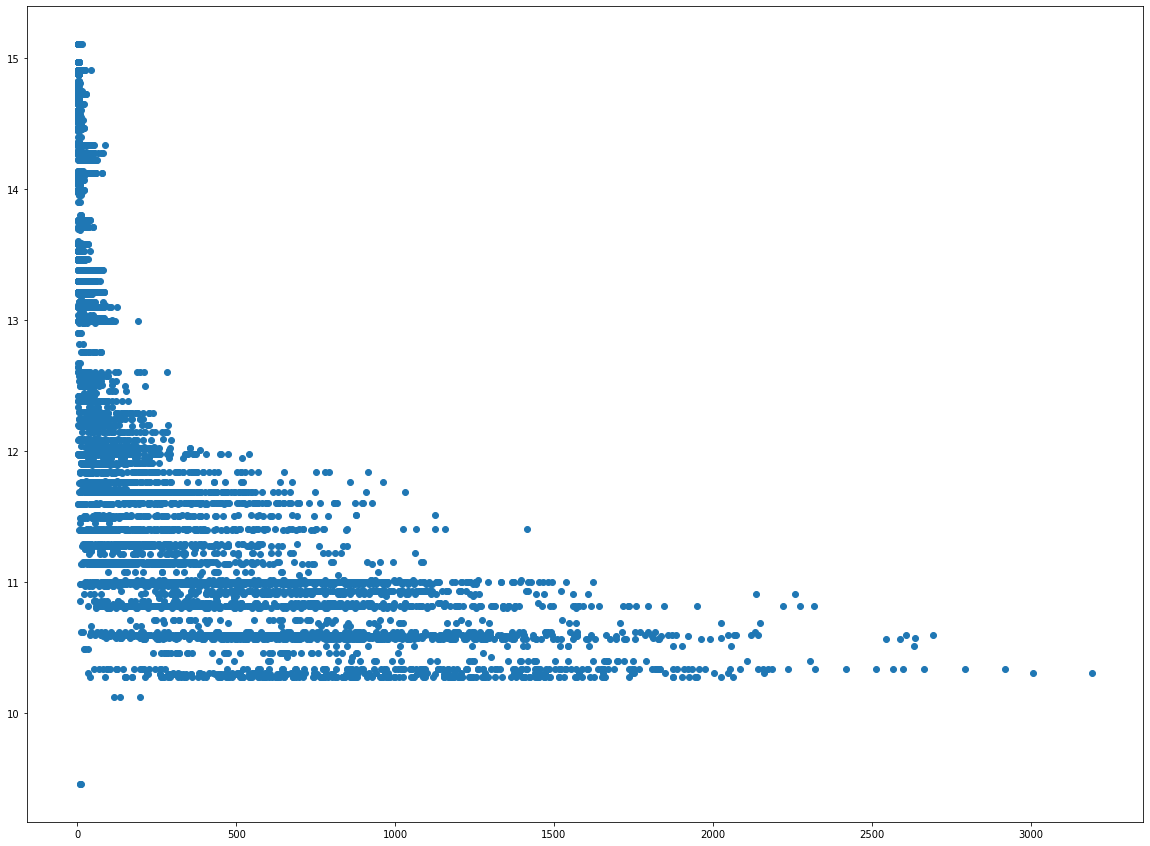

In [358]:
plt.scatter(train['주문량'], np.log(train['판매단가']))